# Data Properties


For many sequential decision making problems we look for some key patterns in the data

* Markov property
* A consistent reward or cost
* Actions being effective in contributing to the reward or affecting the Environment
* Seeing if there is a consistent way that actions are picked

We have a few helper visualisations to help these are `markovian_matrix` and
`normalized_markovian_matrix`.

**Pre-requisite**: this example requires stable-baselines3. To quickly install this library, you may
uncoment and execute the next cell. Note that the term `'gym>=...'` prevents `stable-baselines3`
from downgrading `gym` to a version incompatible with `a2rl`.

In [1]:
# %pip install stable-baselines3 'gym>=0.23.1,<0.26.0'

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import my_nb_path  # isort: skip
import a2rl as wi  # isort: skip
import os

import gym
from IPython.display import Markdown
from stable_baselines3 import A2C, DQN, SAC
from stable_baselines3.common.base_class import BaseAlgorithm

import a2rl.nbtools  # Enable color outputs when rich is installed.
from a2rl.utils import NotMDPDataError, assert_mdp, data_generator_simple, plot_information

/opt/hostedtoolcache/Python/3.10.11/x64/lib/python3.10/site-packages/lightning_fabric/__init__.py:36: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('lightning_fabric')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  __import__("pkg_resources").declare_namespace(__name__)


/opt/hostedtoolcache/Python/3.10.11/x64/lib/python3.10/site-packages/pytorch_lightning/__init__.py:36: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('pytorch_lightning')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  __import__("pkg_resources").declare_namespace(__name__)
/opt/hostedtoolcache/Python/3.10.11/x64/lib/python3.10/site-packages/nptyping/typing_.py:51: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  Bool8 = np.bool8
/opt/hostedtoolcache/Python/3.10.11/x64/lib/python3.10/site-packages/nptyping/typing_.py:54: DeprecationWarning: `np.object0` is a deprecated alias for ``np.object0` is a deprecated alias for `np.object_`. `object` can be used instead.  (Deprecated NumPy 1.24)`.  (Deprecated NumPy 1.24)
  Object0 = np.object0
/opt/hostedtoolc

## Helper Functions

In [3]:
def discretized_sample_dataset(dataset_name: str, n_bins=50) -> wi.WiDataFrame:
    """Discretized a sample dataset.

    Args:
        dataset_name: name of the sample dataset.

    Returns:
        Whatif dataframe.

    See Also
    --------
    list_sample_datasets
    """
    dirname = wi.sample_dataset_path(dataset_name)
    tokeniser = wi.DiscreteTokenizer(n_bins=n_bins)
    df = tokeniser.fit_transform(wi.read_csv_dataset(dirname))
    return df


def data_generator_gym(
    env_name: str = "Taxi-v3",
    trainer: type[BaseAlgorithm] = A2C,
    training_steps: int = 10000,
    capture_steps: int = 1000,
) -> wi.WiDataFrame:
    """Generate a :class:`a2rl.WiDataFrame` from any well-defined OpenAi gym.
    An agent is trained first for ``training_steps``. Then, capture ``capture_steps`` from the
    trained agent.
    Args:
        env_name: Name of the gym environment.
        trainer: An underlying generator algorithm that supports discrete actions, such as
            :class:`stable_baselines3.dqn.DQN` or :class:`stable_baselines3.a2c.A2C`. Raise an error
            when passing a trainer that does not support discrete actions, such as
            :class:`stable_baselines3.sac.SAC`.
        training_steps: The number of steps to train the generator.
        capture_steps: The number of steps to capture.
    Returns:
        A2RL data frame.
    """
    env = gym.make(env_name, render_mode=None)
    model = trainer(policy="MlpPolicy", env=env, verbose=False)
    model.learn(total_timesteps=training_steps)

    cap_env = wi.TransitionRecorder(env)
    model.set_env(cap_env)
    model.learn(total_timesteps=capture_steps)

    tokeniser = wi.DiscreteTokenizer(n_bins=50)
    df = tokeniser.fit_transform(cap_env.df)

    return df


def test_gym_generator():
    import pytest

    gym_data = data_generator_gym(env_name="Taxi-v3", trainer=DQN)
    assert isinstance(gym_data, wi.WiDataFrame)

    with pytest.raises(AssertionError, match=r"Discrete(.*) was provided"):
        gym_data = data_generator_gym(env_name="MountainCar-v0", trainer=SAC)

In [4]:
lags = 10  # Same as assert_mdp()'s default.

################################################################################
# To run in fast mode, set env var NOTEBOOK_FAST_RUN=1 prior to starting Jupyter
################################################################################
if os.environ.get("NOTEBOOK_FAST_RUN", "0") != "0":
    lags = 5
    display(
        Markdown(
            '<p style="color:firebrick; background-color:yellow; font-weight:bold">'
            "NOTE: notebook runs in fast mode. Use only 5 lags. Results may differ."
        )
    )
################################################################################

<p style="color:firebrick; background-color:yellow; font-weight:bold">NOTE: notebook runs in fast mode. Use only 5 lags. Results may differ.

## Data Inspection

In the offline setting we are restricted only to data. A2RL offers three ways to generate some:

1. The load-and-discretize workflow <- The main one. See `discretized_sample_dataset()`.

2. `data_generator_gym` to load data interations between a trained agent and a gym environment <- This is for testing and research

3. `data_generator_simple` to generate sample data with different properties <- Also for testing and research

### Synthetic Data


Create Markov property and then add random actions (random policy) that affect the states. 

Continue this example despite MDP check errors:
 These tests fail MDP checks: ['Reward Function f(state,action)=> reward', 'Action Contribution f(action)=> reward']


Test
Markov Order f(state,action)=> next_state    Lag_1
Reward Function f(state,action)=> reward       NaN
Action Contribution f(action)=> reward         NaN
Action Effectiveness f(action)=> state       Lag_1
dtype: object


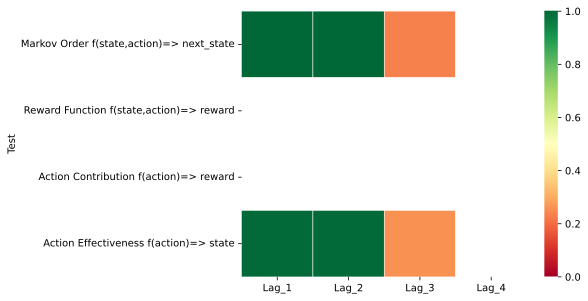

In [5]:
offline_data = data_generator_simple(
    markov_order=1,
    reward_function=False,
    action_effect=True,
    policy=False,
)

try:
    assert_mdp(offline_data, lags=lags)
except NotMDPDataError as e:
    print("Continue this example despite MDP check errors:\n", e)

plot_information(offline_data, lags=lags);

Use higher order Markov property and effective actions, and add a reward function that is related to the state and action

Test
Markov Order f(state,action)=> next_state    Lag_1
Reward Function f(state,action)=> reward     Lag_1
Action Contribution f(action)=> reward       Lag_2
Action Effectiveness f(action)=> state       Lag_2
dtype: object


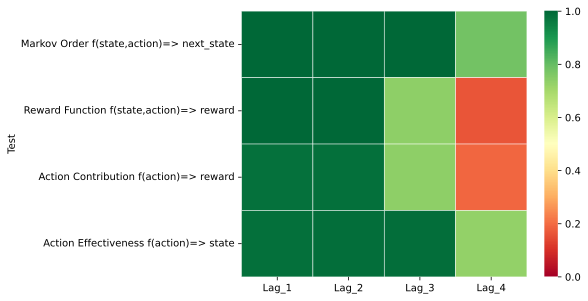

In [6]:
offline_data = data_generator_simple(
    markov_order=2,
    reward_function=True,
    action_effect=True,
    policy=False,
)

try:
    assert_mdp(offline_data, lags=lags)
except NotMDPDataError as e:
    print("Continue this example despite MDP check errors:\n", e)

plot_information(offline_data, lags=lags);

### OpenAi gym environment with known MDP

Use an agent that is not trained very much on Taxi dataset and see how's the data looks like.

/opt/hostedtoolcache/Python/3.10.11/x64/lib/python3.10/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/opt/hostedtoolcache/Python/3.10.11/x64/lib/python3.10/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/opt/hostedtoolcache/Python/3.10.11/x64/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


/opt/hostedtoolcache/Python/3.10.11/x64/lib/python3.10/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/opt/hostedtoolcache/Python/3.10.11/x64/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/opt/hostedtoolcache/Python/3.10.11/x64/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  warnings.warn(
/opt/hostedtoolcache/Python/3.10.11/x64/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 

Test
Markov Order f(state,action)=> next_state    Lag_1
Reward Function f(state,action)=> reward     Lag_3
Action Contribution f(action)=> reward         NaN
Action Effectiveness f(action)=> state       Lag_1
dtype: object
CPU times: user 1.84 s, sys: 20.2 ms, total: 1.86 s
Wall time: 1.79 s


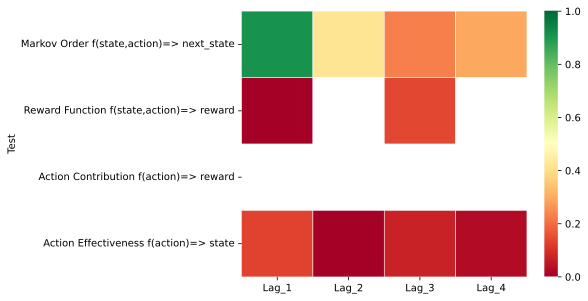

In [7]:
%%time
from stable_baselines3 import DQN

gym_data = data_generator_gym(
    env_name="Taxi-v3",
    trainer=DQN,
    training_steps=10000,
    capture_steps=100,
)

try:
    assert_mdp(offline_data, lags=lags)
except NotMDPDataError as e:
    print("Continue this example despite MDP check errors:\n", e)

plot_information(gym_data, lags=lags);

### Chiller Data

Continue this example despite MDP check errors:
 These tests fail MDP checks: ['Markov Order f(state,action)=> next_state', 'Action Contribution f(action)=> reward', 'Action Effectiveness f(action)=> state']


Test
Markov Order f(state,action)=> next_state   NaN
Reward Function f(state,action)=> reward    NaN
Action Contribution f(action)=> reward      NaN
Action Effectiveness f(action)=> state      NaN
dtype: float64
CPU times: user 10.4 s, sys: 28.4 ms, total: 10.4 s
Wall time: 10.3 s


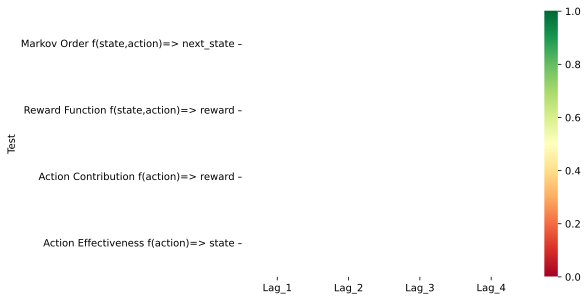

In [8]:
%%time

df_chiller = discretized_sample_dataset("chiller", n_bins=10)
try:
    assert_mdp(df_chiller, lags=lags)
except NotMDPDataError as e:
    print("Continue this example despite MDP check errors:\n", e)

plot_information(df_chiller, lags=lags);